In [1]:
from IPython.display import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
sns.set(rc={'figure.figsize':(6,8)}) 

import warnings
warnings.simplefilter("ignore")

%matplotlib inline

from sklearn.preprocessing import LabelEncoder 

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from sklearn import metrics

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.metrics import SCORERS
import re

import nltk 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
data = pd.read_csv('data_privacy_tweets.csv')

In [3]:
data = data.drop_duplicates('text')
data.head()

,user_id,status_id,created_at,screen_name,text,source,display_text_width,reply_to_status_id,reply_to_user_id,reply_to_screen_name,...,statuses_count,favourites_count,account_created_at,verified,profile_url,profile_expanded_url,account_lang,profile_banner_url,profile_background_url,profile_image_url
0,x1166589525386301440,x1404485195676459008,2021-06-14 17:05:39,privacy_issues,The @EFF finds that the proposed modifications...,TweetDeck,248,NaN,NaN,NaN,...,1036,2177,2019-08-28 05:53:33,False,https://t.co/HFMGW8U18M,http://bit.ly/privacyissuessignup,NaN,https://pbs.twimg.com/profile_banners/11665895...,NaN,http://pbs.twimg.com/profile_images/1166589644...
1,x1166589525386301440,x1403010409473449986,2021-06-10 15:25:22,privacy_issues,The European Parliament passes the new #EU #CO...,TweetDeck,223,NaN,NaN,NaN,...,1036,2177,2019-08-28 05:53:33,False,https://t.co/HFMGW8U18M,http://bit.ly/privacyissuessignup,NaN,https://pbs.twimg.com/profile_banners/11665895...,NaN,http://pbs.twimg.com/profile_images/1166589644...
2,x1166589525386301440,x1404185087093182465,2021-06-13 21:13:07,privacy_issues,To gain better control over the increasingly p...,TweetDeck,240,NaN,NaN,NaN,...,1036,2177,2019-08-28 05:53:33,False,https://t.co/HFMGW8U18M,http://bit.ly/privacyissuessignup,NaN,https://pbs.twimg.com/profile_banners/11665895...,NaN,http://pbs.twimg.com/profile_images/1166589644...
3,x1166589525386301440,x1401833811940306947,2021-06-07 09:30:00,privacy_issues,What if the consumers are on the driving seat ...,TweetDeck,255,NaN,NaN,NaN,...,1036,2177,2019-08-28 05:53:33,False,https://t.co/HFMGW8U18M,http://bit.ly/privacyissuessignup,NaN,https://pbs.twimg.com/profile_banners/11665895...,NaN,http://pbs.twimg.com/profile_images/1166589644...
4,x1166589525386301440,x1401555697163280387,2021-06-06 15:04:52,privacy_issues,"""Vera Jourová says new rules are needed to lim...",TweetDeck,230,NaN,NaN,NaN,...,1036,2177,2019-08-28 05:53:33,False,https://t.co/HFMGW8U18M,http://bit.ly/privacyissuessignup,NaN,https://pbs.twimg.com/profile_banners/11665895...,NaN,http://pbs.twimg.com/profile_images/1166589644...


In [4]:
data.shape

(10637, 90)

In [5]:
df = data[["text", "is_quote", "is_retweet", "retweet_count", "hashtags", "followers_count"]]

In [6]:
text = df[["text"]][:10000] # using subset for now so it will run faster
pd.set_option('display.max_colwidth', -1)
text.head()

,text
0,"The @EFF finds that the proposed modifications to the HIPAA would ""invade your most personal and intimiate health data."" \r\n\r\nStating that trust in healthcare is crucial and especially so during the #COVID pandemic.\r\n\r\nRead more: https://t.co/ReuoQ3mF9p"
1,The European Parliament passes the new #EU #COVID19 Certificate Regulation detailing peoples' COVID information.\r\n\r\nPromising that all personal data will be processed in line with the #GDPR\r\n\r\nRead more: https://t.co/8PGuChsV5F
2,"To gain better control over the increasingly powerful technology sector in #China, new regulations in China make it harder for big tech to refuse the government's request for #datasharing. \r\n\r\n#datasecurity\r\n\r\nRead more: https://t.co/piSfs3NW4J"
3,What if the consumers are on the driving seat to agree or disagree to the #privacypolicy of the #tech giants? Article by Beth Magnuson\r\nexplains #DataPrivacy &amp; #innovation on @VentureBeat \r\n\r\nhttps://t.co/n2pFOwWSmi\r\n\r\n#PrivacyTech #Technology #DataPrivacy
4,"""Vera Jourová says new rules are needed to limit the bulk collection of Europeans’ data.""\r\n\r\nThe #EU is requiring new legislation limiting #US government agencies from accessing European data. \r\n\r\nRead more at: https://t.co/04avhPjhCd"


# Data cleaning

In [7]:
wnet = WordNetLemmatizer()
port = PorterStemmer()

In [14]:
def cleanTxt(txt):
    txt = txt.lower()
    txt = re.sub(r'RT[\s]+', '', txt) #removing RT
    txt = re.sub(r'[^\w\s]','', txt) #remove everything except words and space
    txt = re.sub(r'_','', txt) #how to remove underscore as well
    txt = re.sub('\r\n', '', txt)
    txt = re.sub('amp', '', txt) # removing ampersand
    if 'https' in txt: # removing hyperlinks 
        pos = txt.find('https')
        txt = txt[:pos]
    return txt

In [15]:
text['text'] = text['text'].apply(cleanTxt)
text.head()

,text
0,the eff finds that the proposed modifications to the hipaa would invade your most personal and intimiate health data stating that trust in healthcare is crucial and especially so during the covid pandemicread more
1,the european parliament passes the new eu covid19 certificate regulation detailing peoples covid informationpromising that all personal data will be processed in line with the gdprread more
2,to gain better control over the increasingly powerful technology sector in china new regulations in china make it harder for big tech to refuse the governments request for datasharing datasecurityread more
3,what if the consumers are on the driving seat to agree or disagree to the privacypolicy of the tech giants article by beth magnusonexplains dataprivacy innovation on venturebeat
4,vera jourová says new rules are needed to limit the bulk collection of europeans datathe eu is requiring new legislation limiting us government agencies from accessing european data read more at


In [16]:
def stopWords(txt): 
    txt_lst = txt.split(" ")
    txt_lst = [word for word in txt_lst if word not in stopwords.words('english')]
    txt_lst = [wnet.lemmatize(word) for word in txt_lst]
    txt_lst = [word for word in txt_lst if word != '']
    txt_lst = [word for word in txt_lst if word != 'u0001f449'] # indicates back hand emoji pointing right
    txt_lst = [word for word in txt_lst if word != 'data']
    txt_lst = [word for word in txt_lst if word != 'privacy']
    txt_lst = [word for word in txt_lst if word != 'u']
    return " ".join(txt_lst)

In [17]:
text['text'] = text['text'].apply(stopWords)
text.head()

,text
0,eff find proposed modification hipaa would invade personal intimiate health stating trust healthcare crucial especially covid pandemicread
1,european parliament pass new eu covid19 certificate regulation detailing people covid informationpromising personal processed line gdprread
2,gain better control increasingly powerful technology sector china new regulation china make harder big tech refuse government request datasharing datasecurityread
3,consumer driving seat agree disagree privacypolicy tech giant article beth magnusonexplains dataprivacy innovation venturebeat
4,vera jourová say new rule needed limit bulk collection european datathe eu requiring new legislation limiting government agency accessing european read


# Vectorizing Data

Vectorizing using Binary Term Frequency (https://towardsdatascience.com/getting-started-with-text-vectorization-2f2efbec6685). Binary Term Frequency captures presence (1) or absence (0) of term in document. For this part, under TfidfVectorizer, we set binary parameter equal to true so that it can show just presence (1) or absence (0) and norm parameter equal to false.

In [18]:
text_lst = []
for row in text['text']:
    text_lst.append(row)

text_lst[:5]

['eff find proposed modification hipaa would invade personal intimiate health stating trust healthcare crucial especially covid pandemicread',
 'european parliament pass new eu covid19 certificate regulation detailing people covid informationpromising personal processed line gdprread',
 'gain better control increasingly powerful technology sector china new regulation china make harder big tech refuse government request datasharing datasecurityread',
 'consumer driving seat agree disagree privacypolicy tech giant article beth magnusonexplains dataprivacy innovation venturebeat',
 'vera jourová say new rule needed limit bulk collection european datathe eu requiring new legislation limiting government agency accessing european read']

In [19]:
tv = TfidfVectorizer(
binary = True, norm = None,
use_idf = False, smooth_idf = False,
lowercase = True, stop_words = None,
min_df = 1, max_df = 1.0, max_features = None, ngram_range = (1,1))

In [20]:
text_vec = pd.DataFrame(tv.fit_transform(text_lst).toarray(), columns = tv.get_feature_names())
text_vec.head()

,0001860173,007cybersecurity,01,010,0100,020,05,050,06,0613you,...,zoomecertificates,zoominfo,zootokenio,zscaler,zuboff,zuck,zuckerberg,zumbullaw,zunit14,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# List of Words

In [ ]:
cs_words = []

for row in text['text']:
    for word in str(row).split(" "):
        cs_words.append(word)
        
cs_words[:5]

In [ ]:
len(cs_words)

In [ ]:
from nltk.probability import FreqDist
fdist = FreqDist()
for word in cs_words:
    fdist[word]+=1
fdist

In [ ]:
freq_data = pd.DataFrame.from_dict(fdist.most_common(20))

In [ ]:
sns.barplot(data = freq_data, x = 1, y = 0);

In [ ]:
most_common = []

for key in fdist.most_common(20):
    most_common.append(key[0])
    
most_common

# Clustering

In [ ]:
def evaluate_k_kmeans_inertia(k):
    print(f"running Kmeans with k={k}")
    estimator_kmeans = KMeans(random_state=42, n_clusters=k)
    estimator_kmeans.fit(text_vec)
    return estimator_kmeans.inertia_

In [ ]:
%%time 
range_k = [i for i in range(1, 4)]
results_k = {}
for k in range_k:
    results_k[k] = evaluate_k_kmeans_inertia(k)

In [ ]:
results_k

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.lineplot(
    [c[0] for c in results_k.items()],
    [c[1] for c in results_k.items()], label="inertia", color="red")
ax.set_xlabel("K")
ax.set_ylabel("inertia")
ax.set_title("Inertia by K")
ax.legend();
# try 2, 3, 8 clusters.

## Cluster Analysis

In [ ]:
estimator_kmeans = KMeans(random_state=42, n_clusters=3) # try 2, 3, 8 clusters.
estimator_kmeans.fit(text_vec)

In [ ]:
text_vec["cluster_id"] = estimator_kmeans.labels_
text_vec.head()

In [ ]:
text_clusters = text_vec.groupby('cluster_id').sum()
text_clusters.head()

In [ ]:
text_clusters_20 = text_clusters[['new',
 'apple',
 'security',
 'amp',
 'user',
 'protection',
 'policy',
 'company',
 'personal',
 'law',
 'concern',
 'tiktok',
 'google',
 'social',
 'biometric',
 'right',
 'medium',
 'information',
 'ensure',
 'people']
]

text_clusters_20.head()

In [ ]:
fig, ax = plt.subplots(figsize=(25,15))
sns.heatmap(text_clusters_20.transpose(), annot=False)
plt.title("Cluster Analysis based on Twitter Posts using the Top 20 Words", size = 30);

# Wordcloud

In [ ]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text) # bug here
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# mary: interesting that we have invade (negative), HIPAA, and health. health privacy is pretty important.

# Sentiment Analysis

In [22]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sid_obj = SentimentIntensityAnalyzer()
text['scores'] = text['text'].apply(lambda review: sid_obj.polarity_scores(review))

In [23]:
text.head()

,text,scores
0,eff find proposed modification hipaa would invade personal intimiate health stating trust healthcare crucial especially covid pandemicread,"{'neg': 0.0, 'neu': 0.829, 'pos': 0.171, 'compound': 0.5106}"
1,european parliament pass new eu covid19 certificate regulation detailing people covid informationpromising personal processed line gdprread,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
2,gain better control increasingly powerful technology sector china new regulation china make harder big tech refuse government request datasharing datasecurityread,"{'neg': 0.081, 'neu': 0.586, 'pos': 0.333, 'compound': 0.7845}"
3,consumer driving seat agree disagree privacypolicy tech giant article beth magnusonexplains dataprivacy innovation venturebeat,"{'neg': 0.139, 'neu': 0.588, 'pos': 0.273, 'compound': 0.3612}"
4,vera jourová say new rule needed limit bulk collection european datathe eu requiring new legislation limiting government agency accessing european read,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"


In [25]:
text['compound']  = text['scores'].apply(lambda score_dict: score_dict['compound'])
text.head()

,text,scores,compound
0,eff find proposed modification hipaa would invade personal intimiate health stating trust healthcare crucial especially covid pandemicread,"{'neg': 0.0, 'neu': 0.829, 'pos': 0.171, 'compound': 0.5106}",0.5106
1,european parliament pass new eu covid19 certificate regulation detailing people covid informationpromising personal processed line gdprread,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000
2,gain better control increasingly powerful technology sector china new regulation china make harder big tech refuse government request datasharing datasecurityread,"{'neg': 0.081, 'neu': 0.586, 'pos': 0.333, 'compound': 0.7845}",0.7845
3,consumer driving seat agree disagree privacypolicy tech giant article beth magnusonexplains dataprivacy innovation venturebeat,"{'neg': 0.139, 'neu': 0.588, 'pos': 0.273, 'compound': 0.3612}",0.3612
4,vera jourová say new rule needed limit bulk collection european datathe eu requiring new legislation limiting government agency accessing european read,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000


In [29]:
text['comp_score'] = text['compound'].apply(lambda c: 'pos' if c >=0.05 else ('neg' if c <= -0.05 else 'neutral'))

text.head()

,text,scores,compound,comp_score
0,eff find proposed modification hipaa would invade personal intimiate health stating trust healthcare crucial especially covid pandemicread,"{'neg': 0.0, 'neu': 0.829, 'pos': 0.171, 'compound': 0.5106}",0.5106,pos
1,european parliament pass new eu covid19 certificate regulation detailing people covid informationpromising personal processed line gdprread,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000,neutral
2,gain better control increasingly powerful technology sector china new regulation china make harder big tech refuse government request datasharing datasecurityread,"{'neg': 0.081, 'neu': 0.586, 'pos': 0.333, 'compound': 0.7845}",0.7845,pos
3,consumer driving seat agree disagree privacypolicy tech giant article beth magnusonexplains dataprivacy innovation venturebeat,"{'neg': 0.139, 'neu': 0.588, 'pos': 0.273, 'compound': 0.3612}",0.3612,pos
4,vera jourová say new rule needed limit bulk collection european datathe eu requiring new legislation limiting government agency accessing european read,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000,neutral


In [37]:
comp_score_counts = text.comp_score.value_counts()
# weirdly a good chunk of them are actually postiive

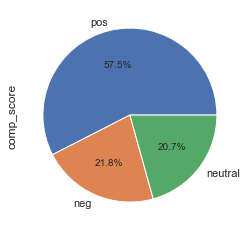

In [38]:
comp_score_counts.plot.pie(autopct="%.1f%%");